# QAOA - Quantum Approximate Optimization Algorithm

In this notebook I would like to show you one of the most prominent algorithms in the quantum computing in the last few years.

In this tutorial you will learn the following:
- How to use pyQuil - python platform for quantum computing.
- How to solve MaxCut problem using QAOA implementation in pyQuil.
- What does it mean in practice that quantum computing is probabilistic.
- Basic information about how QAOA works.

This is probably the most theoretical notebook in this series, especially the second part. If you get discouraged by this and don't get everything, don't worry. Take your time, try reading different resources or just go to the next part and come back later. These ideas are that difficult, but are pretty complicated at times and they may just need some time to sink in :)

## Prerequisites

Before we can go into QAOA itself, you should prepare a couple of things:
1. Configure your Forest API Key - go to http://forest.rigetti.com, find section "Get API Key" and follow the instructions
2. Install [pyQuil](https://github.com/rigetticomputing/pyquil) and [Grove](https://github.com/rigetticomputing/grove)
3. Learn the basics of quantum computing by yourself - there are plenty of great resources about the basics in the web and I decided I don't want to reinvent the wheel in this tutorial. I recommend going to [pyQuil documentation](http://pyquil.readthedocs.io/en/stable/).
4. You can also check out [this tutorial](https://github.com/markf94/rigetti_training_material) by guys from [ProteinQure](https://proteinqure.com). It was designed for the workshops, not self-learning, but there are many hands-on exercises and it will be a good test of your pyQuil skills :)

Even though I tried to make this tutorial as accessible to the not-quantum-computing people as possible, you probably need some level of familiarity with the following concepts:
- qubits
- quantum gates
- superposition
- entanglement

You don't need to go very in-depth - I think spending about 30 minutes with the pyQuil docs should be enough for the beginning. And if something is still confusing later on you can always come back to the documentation when you need it :)


### Terminology

We need this line to have a proper [bra-ket](https://en.wikipedia.org/wiki/Bra–ket_notation) formatting in markdown.
$$
\newcommand{\ket}[1]{\left| #1 \right\rangle}
\newcommand{\bra}[1]{\left\langle #1 \right|}
$$

I try to use as easy language as possible and by easy I mean not very specific neither for physicists, programmers nor quantum computing people. But sometimes it's just not possible, so here I will try to explain you some important concepts in layman terms. These explanation won't give you deep understanding, rather a general overview.

`Operator` - well... if you are not very mathematically accurate, you can treat "operator" as a fancy name for a matrix. If you are - I'm not the best person to explain it to you ;) But in essence, operators represents some kind of action on a quantum state and there is a matrix associated with every operator, so these terms are sometimes used interchangeably.

`Hamiltonian` is an operator describing the quantum system. It's eigenvalues represent the energy values that the system can have.

`Pauli matrix` is one of the three 2x2 matrices commonly used in quantum computing. They have very interesting properties ([wiki](https://en.wikipedia.org/wiki/Pauli_matrices)) and they correspond to some very basic operations on qubits. You will see a lot of them while doing quantum computing.

- $\sigma_x$ -> X gate. It flips $\ket 0$ and $\ket 1$, so it's equivalent to logical NOT gate.
- $\sigma_y$ -> Y gate. It maps $\ket 0$ into $i \ket 1$ and $\ket 1$ into $-i \ket 0$
- $\sigma_z$ -> Z gate. It doesn't affect $\ket 0$ state, but changes $\ket 1$ -> - $\ket 1$



## QAOA - intro

QAOA is an algorithm for solving a broad range of optimization problems using NISQ (Noisy Intermediate-Scale Quantum) devices. 

Let's start easy and instead of going straight to the TSP we will solve MaxCut problem. This part is based on the [Rigetti's tutorial on QAOA](https://grove-docs.readthedocs.io/en/latest/qaoa.html).

### MaxCut - explanation

In the MaxCut problem we start with a graph and we want to divide it into two subgraphs in such way, that the edges between them would have the highest possible sum.

Let's take look on an example. We will color the nodes with blue and red to distinguish into which group they fall - let's say blue represents 0 and red represents 1.

We start easy with a graph with two nodes and one connection:
![](images/02_2_nodes.png)

We can color it in the following ways:
![](images/02_2_nodes_cuts.png)

Now, a little more advanced example:
![](images/02_3_nodes_cuts.png)

To understand it better I recommend drawing a 4-node graph on a paper and try to solve it by hand.

If you still don't get it, check out [this section of the Rigetti's tutorial](https://grove-docs.readthedocs.io/en/latest/qaoa.html#our-first-np-hard-problem).

### QAOA solves MaxCut - quick take

Let's take a graph with four nodes.
We encode it as a list of tuples, where each tuple represents an edge between given nodes.

In [3]:
first_graph = [(0, 1), (0, 2), (0, 3)]

![](images/02_4_nodes.png)
The optimal solution for this graph is either 1000 or 0111:

Now let's try to solve MaxCut problem for this graph using maxcut_solver from the grove library.

Keep in mind that runtime of this algorithm are non-deterministic - it should finish running under a minute, but sometimes it takes longer.

In [4]:
import numpy as np
from grove.pyqaoa.maxcut_qaoa import maxcut_qaoa
import pyquil.api as api
qvm_connection = api.QVMConnection()

In [5]:
%%capture 
#%%capture supresses printing. 
#get_angles() prints out a lot of stuff that we don't care about right now.
maxcut_solver = maxcut_qaoa(graph=first_graph)
betas, gammas = maxcut_solver.get_angles()

Now that we have the values of betas and gammas we can run the actual program.

In [6]:
angles = np.hstack((betas, gammas))
param_prog = maxcut_solver.get_parameterized_program()
prog = param_prog(angles)
qubits = [0, 1, 2, 3]
measurements = qvm_connection.run_and_measure(prog, qubits, trials=1000)

And see what are the results:

In [7]:
from collections import Counter
measurements = [tuple(measurement) for measurement in measurements]
measurements_counter = Counter(measurements)
measurements_counter.most_common()

[((1, 0, 0, 0), 231),
 ((0, 1, 1, 1), 220),
 ((1, 1, 0, 0), 84),
 ((1, 0, 0, 1), 84),
 ((0, 0, 1, 1), 81),
 ((1, 0, 1, 0), 75),
 ((0, 1, 1, 0), 68),
 ((0, 1, 0, 1), 66),
 ((0, 0, 0, 0), 19),
 ((1, 1, 1, 1), 17),
 ((0, 0, 1, 0), 14),
 ((0, 1, 0, 0), 11),
 ((0, 0, 0, 1), 10),
 ((1, 0, 1, 1), 7),
 ((1, 1, 0, 1), 7),
 ((1, 1, 1, 0), 6)]

So as we can see, the correct results are at the top of our lists - so everything seems good.

But why?

We will go through the code step by step in the next section

### QAOA solves MaxCut - details

#### Finding the right angles

In [8]:
# We initialize the maxcut_qaoa object with our graph
maxcut_solver = maxcut_qaoa(graph=first_graph)
# The QAOA algorithm tries to find the optimal values of betas and gammas.
# This line is where all the optimization takes place.
betas, gammas = maxcut_solver.get_angles()
print("Values of betas:", betas)
print("Values of gammas:", gammas)

                     models will be ineffective
	Parameters: [1.54679531 6.139004  ] 
	E => -1.4940854241926789
	Parameters: [1.54679531 6.139004  ] 
	E => -1.497553504498376
	Parameters: [1.54679531 6.139004  ] 
	E => -1.5152091246046904
	Parameters: [1.48395675 5.93756793] 
	E => -1.6630606037921771
	Parameters: [1.48395675 5.93756793] 
	E => -1.6335549243815815
	Parameters: [1.40178325 5.39081289] 
	E => -2.0092685257645435
	Parameters: [1.30269167 5.30927924] 
	E => -2.216995479920419
	Parameters: [1.08879888 4.17500233] 
	E => -2.261790080569641
	Parameters: [1.08879888 4.17500233] 
	E => -2.233258800349405
	Parameters: [1.08879888 4.17500233] 
	E => -2.2509385947021006
	Parameters: [1.08879888 4.17500233] 
	E => -2.2570753231984773
	Parameters: [1.08879888 4.17500233] 
	E => -2.255386716253838
	Parameters: [1.11283539 4.14986029] 
	E => -2.242086582256904
	Parameters: [1.11283539 4.14986029] 
	E => -2.281399329541506
	Parameters: [1.17084493 4.33609311] 
	E => -2.2712914971049964

This time we have not supressed the output and with every iteration of the algorithm you can see two lines being printed.
<br>
The first one is parameters - these are values of betas and gammas.
<br>
The second one is the cost value - it's what we try to minize. As you can probably see, the minimization process isn't ideally smooth. Value is generally getting smaller and smaller, but not necessarily every step yields an improvement.
<br>
We will deal with what exactly this energy means later on.

#### Creating a circuit

In [9]:
# We create an array of angles with correct format
angles = np.hstack((betas, gammas))
print(angles)

[1.17649259 4.10021416]


In [10]:
# We take a template for quil program from the maxcut_solver.
param_prog = maxcut_solver.get_parameterized_program()
# We initialize this program with the angles we have found
prog = param_prog(angles)
# Now we can print the program. 
# Some of the values you see here are the angles we calculated earlier.
print(prog)
print("Number of gates:", len(prog))

H 0
H 1
H 2
H 3
CNOT 0 1
RZ(4.100214159979846) 1
CNOT 0 1
X 0
PHASE(2.050107079989923) 0
X 0
PHASE(2.050107079989923) 0
CNOT 0 2
RZ(4.100214159979846) 2
CNOT 0 2
X 0
PHASE(2.050107079989923) 0
X 0
PHASE(2.050107079989923) 0
CNOT 0 3
RZ(4.100214159979846) 3
CNOT 0 3
X 0
PHASE(2.050107079989923) 0
X 0
PHASE(2.050107079989923) 0
H 0
RZ(-2.3529851869388656) 0
H 0
H 1
RZ(-2.3529851869388656) 1
H 1
H 2
RZ(-2.3529851869388656) 2
H 2
H 3
RZ(-2.3529851869388656) 3
H 3

Number of gates: 37


#### Running the quantum program

In [11]:
# These are just the ids of qubits we want to use.
# It's not very important if you don't use the real QPU.
qubits = [0, 1, 2, 3]
# Here we connect to the Forest API and run our program there.
# We do that 1000 times and after each one we measure the output.
measurements = qvm_connection.run_and_measure(prog, qubits, trials=1000)

#### Analyzing the results

In [12]:
# Since list of 1000 elements is hard to analyze, we use Counter
from collections import Counter
# This is just a hack - we can't use Counter on a list of lists but we can on a list of tuples.
measurements = [tuple(measurement) for measurement in measurements]
measurements_counter = Counter(measurements)
# This line gives us the results in the diminishing order
measurements_counter.most_common()

[((1, 0, 0, 0), 232),
 ((0, 1, 1, 1), 223),
 ((0, 1, 0, 1), 86),
 ((0, 0, 1, 1), 83),
 ((0, 1, 1, 0), 78),
 ((1, 0, 0, 1), 74),
 ((1, 1, 0, 0), 63),
 ((1, 0, 1, 0), 62),
 ((1, 1, 1, 1), 34),
 ((0, 0, 0, 0), 27),
 ((1, 1, 0, 1), 9),
 ((0, 1, 0, 0), 8),
 ((0, 0, 0, 1), 7),
 ((1, 1, 1, 0), 7),
 ((0, 0, 1, 0), 4),
 ((1, 0, 1, 1), 3)]

#### Probabilistic nature of quantum computing

One of the most basic rules of the quantum mechanics is that the act of observation changes the state of the system that we observe. 
<br>
Even though our algorithm produces some state which is a combination of all the states you see above, we can't measure it directly. What we can do (and we did) is to measure it repeatedly and get some distribution of the results.
<br>
Fortunately, we use a simulator and we can look how the state we produced looks exactly:


In [13]:
wf = qvm_connection.wavefunction(prog)
print(wf)

(0.0813147891-0.1300523955j)|0000> + (0.4653262596+0.1064676374j)|0001> + (0.0804387018-0.0324794329j)|0010> + (-0.2535746518+0.1050939054j)|0011> + (0.0804387018-0.0324794329j)|0100> + (-0.2535746518+0.1050939054j)|0101> + (-0.2535746518+0.1050939054j)|0110> + (0.0804387018-0.0324794329j)|0111> + (0.0804387018-0.0324794329j)|1000> + (-0.2535746518+0.1050939054j)|1001> + (-0.2535746518+0.1050939054j)|1010> + (0.0804387018-0.0324794329j)|1011> + (-0.2535746518+0.1050939054j)|1100> + (0.0804387018-0.0324794329j)|1101> + (0.4653262596+0.1064676374j)|1110> + (0.0813147891-0.1300523955j)|1111>


This is hard to read and interpret, so let's print it in a different form.

In [14]:
print("Probability amplitudes for all the possible states:")
for state_index in range(maxcut_solver.nstates):
    print(maxcut_solver.states[state_index], wf[state_index])

Probability amplitudes for all the possible states:
0000 (0.08131478909571628-0.13005239547041625j)
0001 (0.4653262595505163+0.10646763736089705j)
0010 (0.08043870178752226-0.03247943285344676j)
0011 (-0.253574651788108+0.10509390542847408j)
0100 (0.08043870178752226-0.032479432853446726j)
0101 (-0.253574651788108+0.10509390542847413j)
0110 (-0.253574651788108+0.10509390542847415j)
0111 (0.08043870178752228-0.03247943285344669j)
1000 (0.08043870178752228-0.03247943285344669j)
1001 (-0.253574651788108+0.10509390542847415j)
1010 (-0.253574651788108+0.10509390542847413j)
1011 (0.08043870178752226-0.032479432853446726j)
1100 (-0.253574651788108+0.10509390542847408j)
1101 (0.08043870178752226-0.03247943285344676j)
1110 (0.4653262595505163+0.10646763736089705j)
1111 (0.08131478909571628-0.13005239547041625j)


These numbers are still not very easy to interpret, but we can calculate the actual probabilities based on this:

In [15]:
print("Probabilities of measuring given states:")
states_with_probs = []
for state_index in range(maxcut_solver.nstates):
    states_with_probs.append([maxcut_solver.states[state_index], np.real(np.conj(wf[state_index])*wf[state_index])])
    print(states_with_probs[-1][0], states_with_probs[-1][1])


Probabilities of measuring given states:
0000 0.023525720493274362
0001 0.22786388563248594
0010 0.007525298303743494
0011 0.07534483298766928
0100 0.007525298303743491
0101 0.07534483298766928
0110 0.0753448329876693
0111 0.007525298303743493
1000 0.007525298303743493
1001 0.0753448329876693
1010 0.07534483298766928
1011 0.007525298303743491
1100 0.07534483298766928
1101 0.007525298303743494
1110 0.22786388563248594
1111 0.023525720493274362


These results correspond nicely with the values we got from the measurement. Not ideally, but you can increase the `trial` parameter to get closer.

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_state_histogram(states_with_probs):
    states = np.array(states_with_probs)[:,0]
    probs = np.array(states_with_probs)[:,1].astype(float)
    n = len(states_with_probs)
    plt.barh(range(n), probs, tick_label=states)
    plt.show()

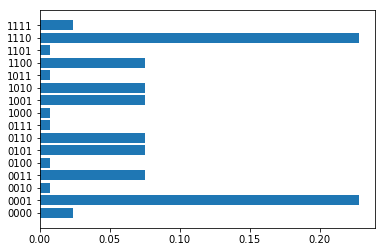

In [17]:
plot_state_histogram(states_with_probs)

#### Exercises

It's a good time to experiment a little bit by yourself. Here are some ideas:

- Run this code on different graphs. 
- Print out what's the distribution of the results. How "convinced" the algorithm is that given solution is correct?
- Try running it several times on one graph. Do you get similar distributions every time?
- How big graphs you can solve with reasonable calculation times?



## QAOA - how does it work?

### Black box approach

The easiest way to look at QAOA is to think only about its inputs and outputs.
<br>
To solve the MaxCut problem the only thing we needed was the graph, which we passed to the instance of `maxcut_qaoa` class. But if you look into [its body](https://github.com/rigetticomputing/grove/blob/master/grove/pyqaoa/maxcut_qaoa.py), you will see that inside we use `qaoa` class with a little bit more advanced version of the following line:

```
QAOA_inst = QAOA(connection, qubits, steps=steps, cost_ham=cost_operators,
                     ref_ham=driver_operators, 
                     init_betas=initial_beta,
                     init_gammas=initial_gamma,
                     minimizer_kwargs=minimizer_kwargs)
```


`connection` is just a regular `api.QVMConnection()` - so we tell QAOA how it should talk to the Forest cloud.

`qubits` are the same qubits that we used earlier.

`steps` is an integer, which specifies how long our quantum program will be. By default it's equal to 1 and that's the value we used in our MaxCut example. We will return to this later.

`cost_ham` (`cost_operators`) is how we encode our problem. This is where all the information about our graph sits and it's encoded as a combination of Pauli operators.

`ref_ham` (`driver_operators`) is how we encode what changes are possible in the realm of our problem. In `maxcut_qaoa` we say that we can flip every qubit from 0 to 1. Again - we use only Pauli operators to create it.

`init_gammas` and `init_betas` are just the initial values for the $\gamma$ and $\beta$ angles.

`minimizer_kwargs` is a dictionary with the minimizer arguments. As you can see in an example below, we specify the minimization method and its options. 
```
minimizer_kwargs = {'method': 'Nelder-Mead',
                            'options': {'ftol': 1.0e-2, 'xtol': 1.0e-2,
                                        'disp': False}}

```

You may wonder why it's a `minimizer` since we want to find a maximum cut. This is due to a nice property of optimization problems, that maximization is just a minimization with of the same problem but with a minus in the cost function. Since most optimization algorithms are stated in terms of minimization, we stick to this convention.

After we have all that we need to run the actual algorithm and find the right angles. Then we create a quantum program which gives us solution to the problem we specified with the `cost_operators`:
```
betas, gammas = QAOA_inst.get_angles()
QAOA_inst.get_parametrized_program()
```

Or actually, we can go straight for the answer with:
```
QAOA_inst.get_string(betas, gammas)
```

This is probably not the simplest black box interface, but honestly, it's not extremely complicated either. The only non-obvious part is what should the cost and driver operators be. Let's see in the next section!

### How to encode our problem

Since in MaxCut we want to create to subsets of nodes, given node is either in set $A$ or $B$.
<br>
The total cost of our solution is: 
<br>
<br>
$C_{total} = \sum C_{ij} = \sum \frac{1}{2} w_{ij} (1 - z_i z_j) $,
<br>
<br>
where the sum goes through all the pairs of nodes and values $z_i$ are equal to 1 if given node is in the set $A$ and -1 if it's in the $B$. $w_{ij}$ is the weight of given edge, which in our current example is equal to 1.
<br>

It turns out that we can construct a matrix (Hamiltonian), which correspons to this cost function using only Pauli operators:
<br>
<br>
$H_{cost} = \sum \frac{1}{2} w_{ij} (\mathbb{1} - \sigma^z_i \sigma^z_j$)
<br>

If you wonder what $\mathbb{1}$ is, it's an identity matrix, which can also be considered as special a Pauli matrix.

How does it look like in the code?

In [18]:
from pyquil.paulis import PauliTerm, PauliSum
import networkx as nx

maxcut_graph = nx.Graph()
for edge in first_graph:
    maxcut_graph.add_edge(*edge)
graph = maxcut_graph.copy()
        
cost_operators = []
for i, j in graph.edges():
    cost_operators.append(PauliTerm("Z", i, 0.5)*PauliTerm("Z", j) + PauliTerm("I", 0, -0.5))


The code above is copied from the `maxcut_qaoa` class. Let's see how some of these operators look:

In [19]:
print(cost_operators[0])
print(cost_operators[1])

(0.5+0j)*Z0*Z1 + (-0.5+0j)*I
(0.5+0j)*Z0*Z2 + (-0.5+0j)*I


This is how we encode our `cost_operators`, so now let's go to the `driver_operators`.
They specify how our state can change. In this basic case, let's say that we allow every qubit to just change from 0 to 1 or otherwise. This means that we need a bunch of X gates (which correspond to $\sigma_x$ Pauli matrices):

In [20]:
driver_operators = []
for i in graph.nodes():
    driver_operators.append(PauliSum([PauliTerm("X", i, -1.0)]))

You don't need to bother with the `PauliSum` function, it's here just so that the input type is correct, but it doesn't play any other role.

In [21]:
print(driver_operators[0])

(-1+0j)*X0


And that's it!
<br>
Now let's try to actually run the QAOA by ourselves:

In [22]:
from grove.pyqaoa.qaoa import QAOA

initial_beta = 0
initial_gamma = 0
minimizer_kwargs = {'method': 'Nelder-Mead',
                            'options': {'ftol': 1.0e-2, 'xtol': 1.0e-2,
                                        'disp': False}}

QAOA_inst = QAOA(qvm_connection, qubits, steps=1, 
                     cost_ham=cost_operators,
                     ref_ham=driver_operators, 
                     init_betas=initial_beta,
                     init_gammas=initial_gamma,
                     minimizer_kwargs=minimizer_kwargs)

In [23]:
betas, gammas = QAOA_inst.get_angles()
print("Values of betas:", betas)
print("Values of gammas:", gammas)
print("And the most common measurement is... ")
most_common_result, _ = QAOA_inst.get_string(betas, gammas)
print(most_common_result)

                     models will be ineffective
Values of betas: [0.39137304]
Values of gammas: [0.95239311]
And the most common measurement is... 
(0, 1, 1, 1)


Awesome! Now you have all the tools to use QAOA, except the most important one...

Knowing how it actually works ;)

### What are betas and gammas?

Imagine you're in the mountains and you want to find the lowest valley. In this analogy if we used the classical gradient descent method, you will start from some point and climb downwards until we can't find anything better. Most of the classical algorithms work this way - you are a moving around the mountain range to find this valley.
<br>
Here it's a little bit different. You start with some simple landscape and standing in the lowest point. Then, very, very slowly, the mountains start erecting from the ground. If this means that the minimum shifts, you do a little step. In the end, the mountains are the same as they were in the previous example and you are standing in the lowest valley.
<br>
What's happening here is the adiabatic transformation from some initial hamiltonian to the hamiltonian representing our problem. It is proven that if it's done slowly enough, the ground state (state of the minimal energy) of the initial hamiltonian will transform smoothly into the ground state of the final hamiltonian. It is also how the quantum annealers work (e.g. D-Wave).
<br>
One of the problems is that using Rigetti's quantum computer (or any other gate based machine) we cannot do this transformation in infinite number of infinitely small steps. We need to set how many steps we want and this is what `steps` parameter does. The more steps we have, the higher chance we will get the good result, but we also need more gates and running the algorithm gets longer and longer. Also, it means we have more betas and gammas to optimize. In this metaphore, betas and gammas tell you how exactly should you add new mountains in each step.

For those of you, who prefer equations over methaphores - below is the short version of how it works. We start with some definitions and then go to the explanations:

${\displaystyle U(C,\gamma) = e^{-i \gamma C} = \prod_{\alpha} e^{-i \gamma C_{\alpha}} }$, where $C_{\alpha}$ are the cost operators we defined earlier.
<br>
${\displaystyle U(B,\beta) = e^{-i \beta B} = \prod_{j} e^{-i \beta B_{j}} }$, where $B_{j}$ are the driver operators we defined earlier.
<br>
$\ket{s}$ is the initial state.
<br>
And finally: $\ket{\beta, \gamma} = U(B, \beta) U(C, \gamma) \ket{s}$
<br>

This is for the case where `steps=2`, but it generalizes nicely to higher number of steps, e.g.:
<br>
$\ket{\beta, \gamma} = U(B, \beta_1) U(B, \beta_0) U(C, \gamma_1) U(C, \gamma_0)\ket{s}$

If you are not familiar with this notation here is a step-by-step description of what does it mean in practice:
- Let's take some initial state $\ket{s}$
- Evolve this state using the operator $U(C, \gamma_0)$ 
- Evolve this state further using the rest of operators, from right to left.

"Evolving" is just a fancy name for "changing" that we use when talking about the states in quantum computing.

And now, if the values of angles $\beta$ and $\gamma$ are the right ones, we get a state which is a ground state of the Hamiltonian defining our problem, which should correspond to our solution.  
If you wonder why we call $\gamma$ and $\beta$ angles, that's because $U(C, \gamma)$ and $U(B, \beta)$ correspond to rotations by angles $\gamma$ and $\beta$ in some high dimensional space.

### How to find the right angles? The hybrid part

QAOA is an iterative algorithm, which in every iteration uses a quantum and a classical part.

**Quantum**
1. Prepare a quantum state based on the current values of $\gamma$ and $\beta$.
2. Measure the state.
3. Repeat many times to get some statistics.

**Classical**

Here we use some classical optimization method, e.g. Nelder-Mead algorithm, and in each iteration of this algorithm we perform the quantum operations to evaluate how good our current angles are.
<br>
The algorithm ends when we can't further improve the angles.

## Summary and next steps

What we learned?

- how to solve MaxCut problem using QAOA
- how to use QAOA class from grove
- how to encode an optimization problem for QAOA
- what the QAOA is and how it works

What's next?

- Solving TSP using QAOA

## Additional resources

- [Pauli matrices](https://en.wikipedia.org/wiki/Pauli_matrices)
- [Original QAOA paper](https://arxiv.org/abs/1411.4028)
- [QAOA Grove docs](https://grove-docs.readthedocs.io/en/latest/qaoa.html)
- [Source code of MaxCut QAOA in Grove](https://github.com/rigetticomputing/grove/blob/master/grove/pyqaoa/maxcut_qaoa.py)
- [Presentation from one of the creators of QAOA](https://youtu.be/J8y0VhnISi8)